In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
class FermiEvents:
    
    def __init__(self, data):
        self.data = data

    @property 
    def theta(self): 
        return self.data[...,0]
    @property 
    def phi(self): 
        return self.data[...,1]
    @property 
    def energy(self): 
        return self.data[...,2]
    @property 
    def data_size(self):
        return self.data.shape[0]
    
    def selection_cuts(self, feature, cut=None):
        if cut is None: cut=[-np.inf, np.inf]
        dic={'theta':0, 'phi':1, 'energy':2}
        mask = (self.data[..., dic[feature]] >= cut[0]) & (self.data[..., dic[feature]] <= cut[1])
        self.data = self.data[mask]
        return self

    def standardize(self, inverse=False, sigma=1, verbose=True):
        if not inverse: 
            if verbose: print('INFO: standardizing data to zero-mean and std={}'.format(sigma)) 
            self.mean = torch.mean(self.data, dim=0)
            self.std = torch.std(self.data, dim=0)
            self.data = (self.data - self.mean) / (self.std / sigma)
        else:
            if verbose: print('INFO: inverting data standardization')
            self.data = self.data * (self.std / sigma) + self.mean

    def normalize(self, inverse=False, verbose=True):
        if not inverse:
            self.max, _ = torch.max(torch.reshape(self.data, (-1,3)), dim=0)
            self.min, _ = torch.min(torch.reshape(self.data, (-1,3)), dim=0)
            if verbose: print('INFO: normalizing data') 
            self.data = (self.data - self.min) / (self.max - self.min) 
        else:
            if verbose: print('INFO: inverting data normalization')
            self.data = self.data * (self.max - self.min) + self.min 

    def logit_transform(self, alpha=1e-6, inverse=False, verbose=True):
        if not inverse:
            if verbose: print('INFO: applying logit transform')
            self.data = logit(self.data, alpha=alpha)
        else:
            if verbose: print('INFO: applying expit transform')
            self.data = expit(self.data, alpha=alpha)
    
    def preprocess(self, reverse=False, sigma=1.0,  alpha=1e-6, verbose=True):  
        if not reverse: 
            self.normalize(verbose=verbose)
            self.logit_transform(alpha=alpha, verbose=verbose)
            self.standardize(sigma=sigma, verbose=verbose)
        else: 
            self.standardize(sigma=sigma, inverse=True, verbose=verbose)
            self.logit_transform(inverse=True, alpha=alpha, verbose=verbose)
            self.normalize(inverse=True, verbose=verbose)

    def plot(self, feature, plot_dir=None, target=None, color='k', bins=100, log_scale=(False, False)):
        dic={'theta':0, 'phi':1, 'energy':2}
        sns.histplot(x=self.data[...,dic[feature]], 
                     color=color, 
                     bins=bins,
                     log_scale=log_scale,
                     element="step", lw=0.75, fill=False, alpha=1) 
        if target is not None:
            feat = target[...,dic[feature]]
            sns.histplot(x=feat, 
                 color=color, 
                 bins=bins,
                 log_scale=log_scale,
                 element="step", lw=0., fill=True, alpha=0.1) 
        if plot_dir is not None:
            plt.savefig(plot_dir+'/{}.pdf'.format(feature))
        plt.show()
        plt.close()

    def plot_milky_way(self, plot_dir=None, cmap='plasma'):
        fig = plt.figure(1,figsize=(6,6))
        ax = fig.add_subplot(111)
        ax.hexbin(self.phi, self.theta, cmap=cmap, gridsize=300, bins='log')
        if plot_dir is not None:
            plt.savefig(plot_dir+'/milky_way.pdf')
        plt.show()
        plt.close()

    

In [140]:
data_file =  "../data/fermi/fermi_data_galactic_coord.npy"
data = torch.tensor(np.load(data_file))  
galaxy_center = FermiEvents(data)
galaxy_center.selection_cuts(feature='energy', cut=[1000, 2000])
galaxy_center.selection_cuts(feature='theta', cut=[-10., 10.])
galaxy_center.selection_cuts(feature='phi', cut=[4., 10.])


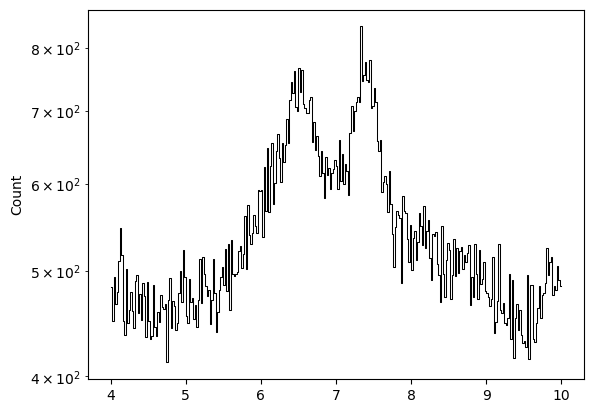

In [141]:
galaxy_center.plot(feature='phi', bins=300, log_scale=(False, True))

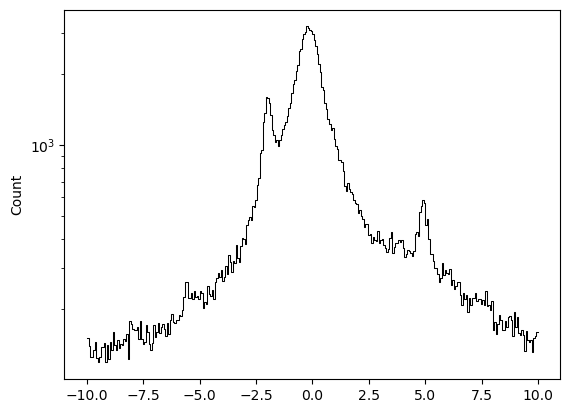

In [142]:
galaxy_center.plot(feature='theta', bins=300, log_scale=(False, True))

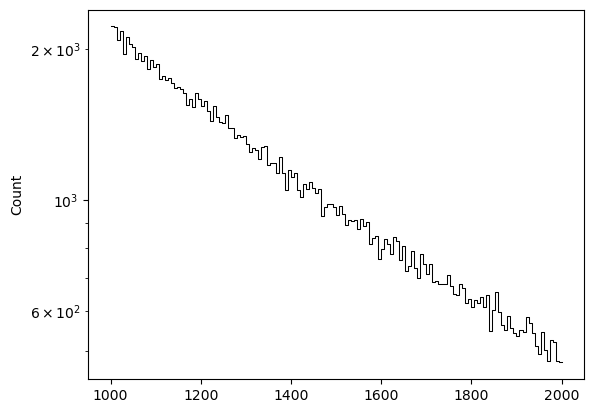

In [143]:
galaxy_center.plot(feature='energy', bins=150, log_scale=(False, True))

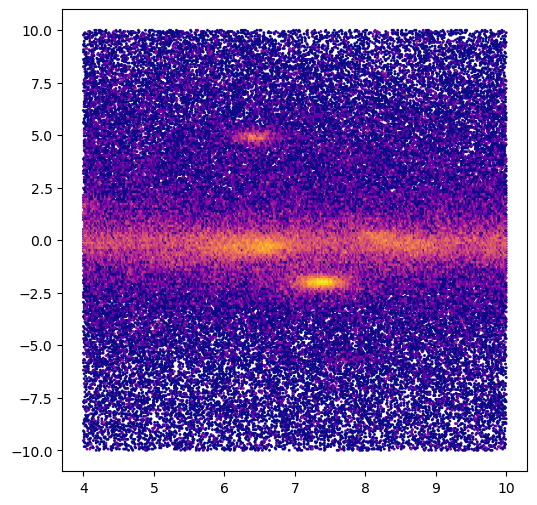

In [144]:
galaxy_center.plot_milky_way()

In [15]:

class FormatData:

    def __init__(self, 
                 data: torch.Tensor=None,
                 cuts: dict=None):
        self.data = data
        self.cuts = cuts if cuts is not None else {'theta': None, 'phi': None, 'energy':None}
    @property 
    def theta(self): 
        return self.data[...,0]
    @property 
    def phi(self): 
        return self.data[...,1]
    @property 
    def energy(self): 
        return self.data[...,2]
    @property 
    def data_size(self):
        return self.data.shape[0]
    
    def selection_cuts(self, feature, cut=None):
        if cut is None: cut=[-np.inf, np.inf]
        dic={'theta':0, 'phi':1, 'energy':2}
        mask = (self.data[..., dic[feature]] >= cut[0]) & (self.data[..., dic[feature]] <= cut[1])
        self.data = self.data[mask]
        return self

    def format(self):
        self.selection_cuts(feature='energy', cut=self.cuts['energy'])
        self.selection_cuts(feature='theta', cut=self.cuts['theta'])
        self.selection_cuts(feature='phi', cut=self.cuts['phi'])


cuts = {'theta': [-10., 10.], 'phi': [4., 10.], 'energy': [1000, 2000]}

sample = FormatData(data, cuts=cuts)
sample.format()
sample.data.shape

torch.Size([162173, 3])

In [31]:

class PreprocessData:

    def __init__(self, 
                 data, 
                 stats,
                 methods: list=['standardize']
                 ):
        
        self.galactic_features = data
        self.mean, self.std, self.min, self.max = stats 
        self.methods = methods

    def preprocess(self):
        for method in self.methods:
            method = getattr(self, method, None)
            if method and callable(method): method()
            else: raise ValueError('Preprocessing method {} not implemented'.format(method))
        
    def standardize(self,  sigma: float=1.0):
        self.galactic_features = (self.galactic_features - self.mean) * (sigma / self.std )

    def normalize(self):
        self.galactic_features = (self.galactic_features - self.min) / ( self.max - self.min )
    
    def logit_transform(self, alpha=1e-6):
        self.galactic_features = self.galactic_features * (1 - 2 * alpha) + alpha
        self.galactic_features = torch.log(self.galactic_features / (1 - self.galactic_features))


In [69]:
import torch
from torch.utils.data import Dataset

class FermiDataset(Dataset):

    def __init__(self, 
                 dir_path: str=None, 
                 cuts: dict=None,
                 preprocess : list=None
                 ):
        
        self.path = dir_path
        self.cuts = cuts
        self.preprocess_methods = preprocess 
        self.summary_statistics = {}
        self.dataset_list = self.get_data()

    def __getitem__(self, idx):
        output = {}
        datasets = self.dataset_list
        galactic_features = self.apply_preprocessing(sample=datasets[idx]) if self.preprocess_methods is not None else datasets[idx] 
        output['target'] = galactic_features
        output['source'] = torch.rand_like(galactic_features)
        output['mask'] = torch.ones_like(galactic_features[...,0], dtype=torch.int8)
        output['context'] = torch.empty_like(galactic_features[..., 0])
        return output

    def __len__(self):
        return self.dataset_list.size(0)
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def get_data(self):
        print("INFO: loading and preprocessing data...")
        dataset = torch.tensor(np.load(self.path))
        dataset = self.apply_formatting(dataset)
        print(dataset.shape)
        print('\t- dataset: {} \n \t- shape: {}'.format(self.path, dataset.shape))
        self.summary_statistics['dataset'] = self.summary_stats(dataset)
        return dataset

    def apply_formatting(self, sample):
        sample = FormatData(sample, cuts=self.cuts)
        sample.format()
        return sample.data
    
    def apply_preprocessing(self, sample):
        sample = PreprocessData(data=sample, 
                                stats=self.summary_statistics['dataset'],
                                methods = self.preprocess_methods
                                )
        sample.preprocess()
        return sample.galactic_features
    
    def summary_stats(self, data):
        mean = torch.mean(data, dim=0)
        std = torch.std(data, dim=0)
        min, _ = torch.min(data, dim=0)
        max, _ = torch.max(data, dim=0)
        return (mean, std, min, max)

fermi = FermiDataset(dir_path=data_file, cuts=cuts)
fermi.summary_statistics['dataset']
print(len(fermi))

INFO: loading and preprocessing data...
torch.Size([162173, 3])
	- dataset: ../data/fermi/fermi_data_galactic_coord.npy 
 	- shape: torch.Size([162173, 3])
162173


In [70]:
fermi = FermiDataset(dir_path=data_file, cuts=cuts, preprocess=['standardize'])
print(fermi.summary_statistics['dataset'])
print(len(fermi))
print(fermi[:3])

INFO: loading and preprocessing data...
torch.Size([162173, 3])
	- dataset: ../data/fermi/fermi_data_galactic_coord.npy 
 	- shape: torch.Size([162173, 3])
(tensor([1.0134e-01, 7.0015e+00, 1.3780e+03], dtype=torch.float64), tensor([  3.5879,   1.6366, 276.1025], dtype=torch.float64), tensor([  -9.9999,    4.0000, 1000.0014], dtype=torch.float64), tensor([   9.9996,   10.0000, 1999.9929], dtype=torch.float64))
162173
{'target': tensor([[ 1.5191, -1.2750,  0.1525],
        [ 0.3039,  0.5094,  1.7261],
        [-0.0298, -0.2507, -1.2122]], dtype=torch.float64), 'source': tensor([[0.4868, 0.7247, 0.1889],
        [0.9585, 0.4165, 0.0301],
        [0.5390, 0.4311, 0.8389]], dtype=torch.float64), 'mask': tensor([1, 1, 1], dtype=torch.int8), 'context': tensor([0., 0., 0.], dtype=torch.float64)}


In [71]:
from torch.utils.data import DataLoader, Subset, ConcatDataset

class FermiDataLoader:

    def __init__(self, 
                 datasets: FermiDataset, 
                 data_split_fracs: list=[0.7, 0.2, 0.1],
                 batch_size: int=1024 
                 ):

        self.datasets = datasets        
        self.data_split_fracs = data_split_fracs
        self.batch_size = batch_size
        self.dataloader()

    def train_val_test_split(self, dataset, train_frac, valid_frac, shuffle=False):
        assert sum(self.data_split_fracs) - 1.0 < 1e-3, "Split fractions do not sum to 1!"
        total_size = len(dataset)
        train_size = int(total_size * train_frac)
        valid_size = int(total_size * valid_frac)
        
        #...define splitting indices

        idx = torch.randperm(total_size) if shuffle else torch.arange(total_size)
        idx_train = idx[:train_size]
        idx_valid = idx[train_size : train_size + valid_size]
        idx_test = idx[train_size + valid_size :]
        
        #...Create Subset for each split

        train_set = Subset(dataset, idx_train)
        valid_set = Subset(dataset, idx_valid)
        test_set = Subset(dataset, idx_test)

        return train_set, valid_set, test_set


    def dataloader(self):

        print("INFO: building dataloaders...")

        #...get training / validation / test samples   

        print("INFO: train/val/test split ratios: {}/{}/{}".format(self.data_split_fracs[0], 
                                                                   self.data_split_fracs[1], 
                                                                   self.data_split_fracs[2]))
        
        train, valid, test = self.train_val_test_split(dataset=self.datasets, 
                                                       train_frac=self.data_split_fracs[0], 
                                                       valid_frac=self.data_split_fracs[1], 
                                                       shuffle=True)

        #...create dataloaders

        self.train = DataLoader(dataset=train, batch_size=self.batch_size, shuffle=True)
        self.valid = DataLoader(dataset=valid,  batch_size=self.batch_size, shuffle=False)
        self.test = DataLoader(dataset=test,  batch_size=self.batch_size, shuffle=True)

        print('INFO: train size: {}, validation size: {}, testing sizes: {}'.format(len(self.train.dataset), 
                                                                                    len(self.valid.dataset), 
                                                                                    len(self.test.dataset)))


In [72]:
dataloder = FermiDataLoader(fermi, data_split_fracs=[0.7, 0.3, 0.0], batch_size=1024)

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.7/0.3/0.0
INFO: train size: 113521, validation size: 48651, testing sizes: 1


In [73]:
dataloder.train.dataset[0]

{'target': tensor([-0.0230, -0.6089,  1.6433], dtype=torch.float64),
 'source': tensor([0.1713, 0.3957, 0.9297], dtype=torch.float64),
 'mask': tensor(1, dtype=torch.int8),
 'context': tensor(0., dtype=torch.float64)}

In [74]:
for batch in dataloder.train:
    print(batch)
    break

{'target': tensor([[-1.8725e-01,  1.1588e+00,  8.4981e-01],
        [-5.1418e-01,  9.7619e-01, -1.2937e+00],
        [-2.2050e+00,  1.2440e+00,  1.1509e-03],
        ...,
        [ 1.9762e+00, -5.9723e-01, -1.2598e+00],
        [ 1.7681e+00,  2.5560e-01, -7.2737e-01],
        [-1.3416e-01,  7.8824e-01,  5.0587e-01]], dtype=torch.float64), 'source': tensor([[0.0785, 0.0099, 0.6750],
        [0.6042, 0.3003, 0.8439],
        [0.5457, 0.4755, 0.3175],
        ...,
        [0.6275, 0.7167, 0.9999],
        [0.0480, 0.2619, 0.9824],
        [0.2398, 0.9787, 0.4683]], dtype=torch.float64), 'mask': tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int8), 'context': tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)}
